# 13wk-2: MCMC (1)

최규빈  
2023-05-30

# 강의영상

> youtube:
> <https://youtube.com/playlist?list=PLQqh36zP38-zyk8psVKy2OaZs3zV4ExWn>

# import

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

# 정리 (low-resolution)

`-` 우리가 하고 싶었던 것: 어떠한 현상에 대하여, 확률공간
$(\Omega,{\cal F}, \mathbb{P})$ 에 대한 완전한 기술

`-` 이것을 수행하는 방법.

-   방법1: $(\Omega,{\cal F}, \mathbb{P})$를 state 하고 “관심있는 어떤
    것”을 이론적으로 구한다.
-   방법2: $\omega \to {\boldsymbol X}(\omega)={\boldsymbol x}$ 를
    무한번 반복 관찰하고 (=시뮬레이션하고!) “관심있는 어떤 것”을
    시뮬레이션으로 근사
-   방법3: 독립적으로 $n$회 관찰된
    $({\boldsymbol x}_1,{\boldsymbol x}_2,\dots,{\boldsymbol x}_n)$ 를
    이용하여 “관심있는 어떤 것”을 추정, 추정 결과를 합리적으로 설득.

`-` 시뮬레이션 가능하면 최고인것 같은데?

`-` 통계학과 최고의 발명품

1.  EM 알고리즘
2.  FDR
3.  부스트랩

# 전통적인 난수생성 방법

## 균등분포

`-` 가정: 균등분포에서는 뽑을 수 있다고 가정한다. (제가 사실 여기는 잘
몰라요)

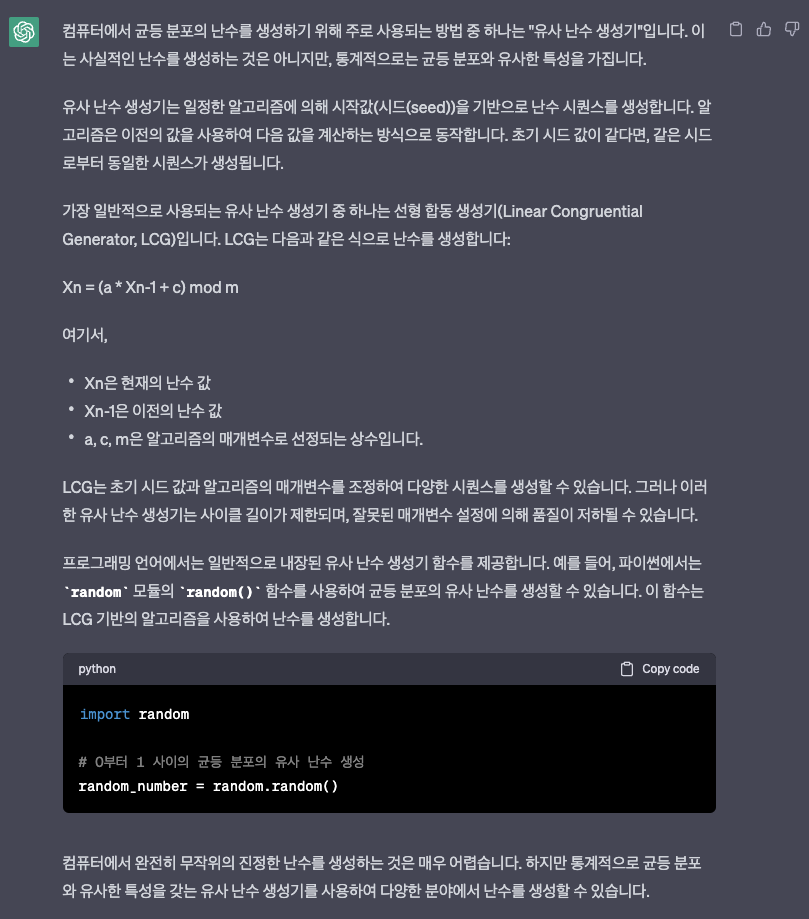

`-` 균등분포 이외의 난수는 어떻게?… (어려워요)

## 베르누이, 이항분포, 포아송, 지수분포

`-` 베르누이

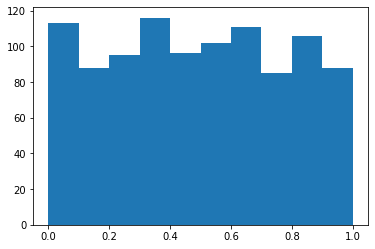

In [4]:
x = np.random.rand(1000)
plt.hist(x);

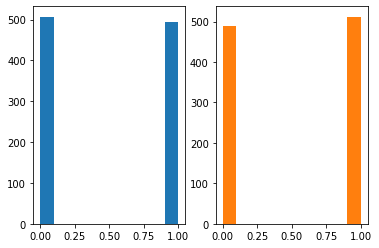

In [5]:
fig, ax = plt.subplots(1,2)
ax[0].hist((x > 0.5)*1.0,color='C0');
ax[1].hist(np.random.binomial(1,0.5,size=1000),color='C1');

-   $X \sim Ber(p)$, $p=0.5$

`-` 이항분포: 베르누이의 합으로!

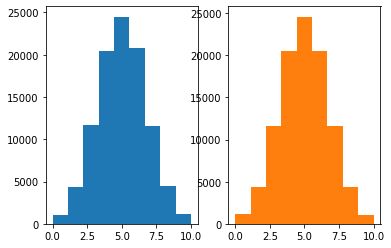

In [6]:
x = np.random.rand(10*100000).reshape(10,100000)
fig, ax = plt.subplots(1,2)
ax[0].hist((x>0.5).sum(axis=0),bins=9);
ax[1].hist(np.random.binomial(10,0.5,size=100000),color='C1',bins=9);

`-` 포아송: 이항분포의 근사로

-   ref: <https://guebin.github.io/SC2022/0324.html>

`-` 지수분포: 포아송 프로세스를 이용하여!

-   ref: <https://guebin.github.io/SC2022/0324.html>

## inverse cdf, 박스뮬러변환

`-` inverse cdf: 지수분포를 뽑는 또 다른 테크닉: (지수분포가 아니더라도
CDF를 알면 뽑을 수 있음)

-   ref: <https://guebin.github.io/SC2022/0329.html>

`-` 박스뮬러변환: 지수분포 + uniform으로 정규분포를 뽑는 테크닉

-   ref: <https://guebin.github.io/SC2022/0329.html>

`-` 카이제곱분포, 감마분포: 지수분포를 이용하면 샘플링가능

-   ref: <https://guebin.github.io/SC2022/0419.html>

# 베타분포를 샘플링 (전통적 방법)

`-` 목표:
$X_1,X_2,X_3,\dots,X_{100000} \overset{i.i.d.}{\sim} {\cal B}(2,6)$

`-` 전략: 아래를 이용한다.

1.  ${\cal B}(2,6) \overset{d}{=} \frac{{\cal G}(2,1)}{{\cal G}(2,1)+{\cal G}(6,1)}$
2.  ${\cal G}(2,1) \overset{d}{=} {\cal E}(1) + {\cal E}(1)$
3.  ${\cal G}(6,1) \overset{d}{=} {\cal E}(1) + {\cal E}(1) +{\cal E}(1)+{\cal E}(1)+{\cal E}(1)+{\cal E}(1)$

`-` inverse cdf를 이용하여 지수분포를 뽑을 수 있다고 가정하자.

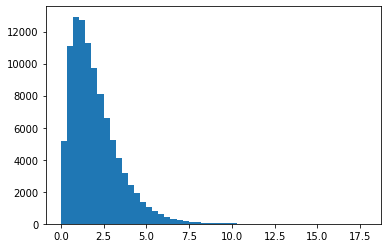

In [7]:
gamma2 = np.random.exponential(scale=1,size=(100000,2)).sum(axis=1)
plt.hist(gamma2,bins=50);

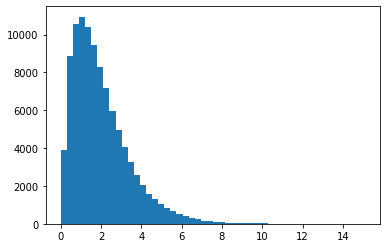

In [8]:
plt.hist(np.random.gamma(shape=2,scale=1,size=100000),bins=50);

In [9]:
gamma6 = np.random.exponential(scale=1,size=(100000,6)).sum(axis=1)

In [10]:
beta26 = gamma2/(gamma2+gamma6)

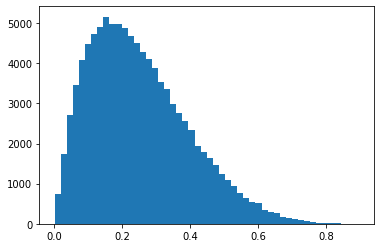

In [11]:
plt.hist(beta26,bins=50);

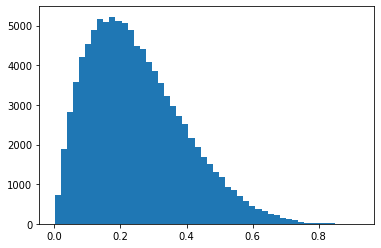

In [12]:
plt.hist(np.random.beta(2,6,size=100000),bins=50);

# 베타분포를 샘플링 (이상한 방식)

## pdf 정의

`-` 모티브: 그냥 pdf를 입력하면 알아서 샘플링되도록 할 수 없나?

`-` 예비학습: 감마함수

In [13]:
scipy.special.gamma(5)

In [14]:
g = scipy.special.gamma

`-` 베타분포의 pdf

$$f_X(x) = \frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)}x^{\alpha-1}(1-x)^{\beta-1}$$

In [15]:
def f(x): 
    return g(2+6)/(g(2)*g(6)) * x**(2-1) * (1-x)**(6-1)

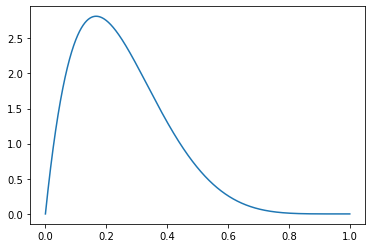

In [16]:
_x = np.linspace(0,1,10000)
plt.plot(_x,f(_x))

## 시도1: 망했음

### ***step1: 초기화***

`-` 베타분포에서 10만개의 샘플을 뽑아보자.

`-` 일단 ${\bf xx}=(x_0,x_1,\dots,x_{T-1})$를 초기화를 하자.

In [17]:
xx=[0.99]
xx

-   현재의 $x_i$값은 $x_0=0.99$ 만 있지만 궁극적으로는
    ${\cal B}(2,6)$에서 생성된 샘플로 채우고 싶다.

### ***step2: 후보 샘플링***

`-` 하나의 $y$ 을 균등분포에서 샘플링한다.

In [18]:
np.random.seed(1)
y = np.random.rand()
y

### ***step3: 비교***

`-` $xx[0]$ vs $y$

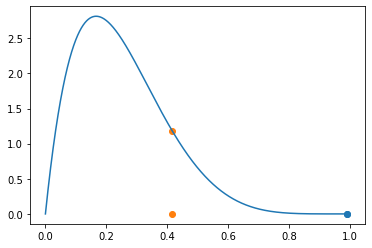

In [19]:
plt.plot(_x,f(_x))
plt.scatter(xx[0],0,color='C0')
plt.scatter(xx[0],f(xx[0]),color='C0')
plt.scatter(y,0,color='C1')
plt.scatter(y,f(y),color='C1')

### ***step4: 선택***

`-` 비교결과: $xx[0]$ 보다 $y$가 나은것 같다

`-` 선택: $xx[1]=y$ 로 하자

> 만약에 $xx[0]$이 $y$보다 나은것 같다면? 그냥 $xx[1]=xx[0]$으로 선택

### ***step 1~4 반복: 망했음***

In [20]:
T = 100000
xx = [0.99]
for t in range(T):
    y = np.random.rand()
    if f(xx[t]) < f(y):
        xx.append(y) 
    else:
        xx.append(xx[t])

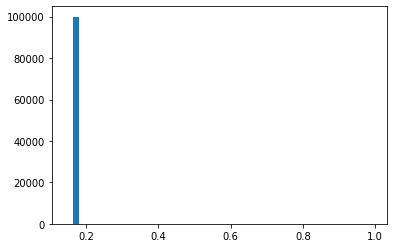

In [23]:
plt.hist(xx,bins=50);

## 시도2: 성공

### ***step1: 초기화***

`-` 베타분포에서 10만개의 샘플을 뽑아보자.

`-` 일단 ${\bf xx}=(x_0,x_1,\dots,x_{T-1})$를 초기화를 하자.

In [149]:
xx=[0.99]
xx

-   현재의 $x_i$값은 $x_0=0.99$ 만 있지만 궁극적으로는
    ${\cal B}(2,6)$에서 생성된 샘플로 채우고 싶다.

### ***step2: 후보 샘플링***

`-` 하나의 $y$ 을 균등분포에서 샘플링한다.

In [150]:
np.random.seed(1)
y = np.random.rand()
y

### ***step3: 비교***

`-` $xx[0]$ vs $y$

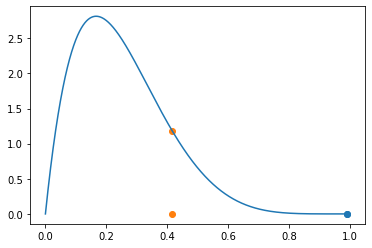

In [151]:
plt.plot(_x,f(_x))
plt.scatter(xx[0],0,color='C0')
plt.scatter(xx[0],f(xx[0]),color='C0')
plt.scatter(y,0,color='C1')
plt.scatter(y,f(y),color='C1')

### ***step4: 선택***

`-` 비교결과: $xx[0]$ 보다 $y$가 나은것 같다

`-` 선택: 그렇지만 무조건 $xx[1]=y$ 로 선택하면 큰일나겠음.. 아래의
확률로 선택하자!

-   확률 $\frac{f(xx[0])}{f(xx[0])+f(y)}$ 로 $xx[1]=xx[0]$을 선택!
-   확률 $\frac{f(y)}{f(xx[0])+f(y)}$ 로 $y$를 선택!

### ***step 1~4 반복: 이게 된다고?***

In [162]:
T = 100000
xx = [0.99]
for t in range(T):
    y = np.random.rand()
    thresh_prob = f(y)/(f(xx[t])+f(y)) ## thresh_prob 가 클수록 y가 선택
    _u = np.random.rand()
    if _u < thresh_prob:
        xx.append(y) 
    else:
        xx.append(xx[t])

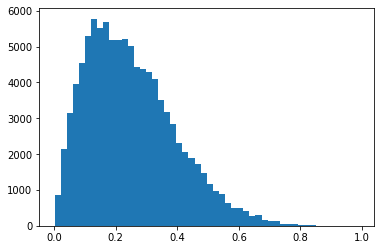

In [163]:
plt.hist(xx,bins=50);

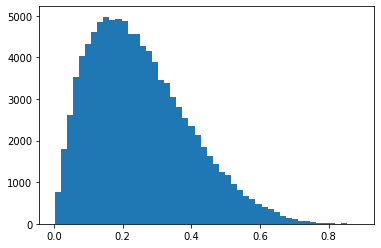

In [159]:
plt.hist(np.random.beta(2,6,size=100000),bins=50);